# CS109b Final Project: 
# Air Pollution Exposure and COVID-19 Mortality in the U.S.

## Import libraries

In [48]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

pd.options.display.max_rows = 500
pd.options.display.max_columns = 500

## Load and clean data

In [2]:
# Read in NYT data
url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv'
nyt_df = pd.read_csv(url,index_col=None,parse_dates=[0])

# Calculate cumulative death rate
nyt_df['death_rate'] = nyt_df['deaths'] / nyt_df['cases']

# Convert date column to datetime object
nyt_df['date'] = pd.to_datetime(nyt_df['date'], format='%d/%m/%Y')

In [3]:
# Read in data
data_04_24 = pd.read_csv('../PM_COVID-master/processed_data_04-24-2020.csv')
data_04_30 = pd.read_csv('../PM_COVID-master/processed_data_04-30-2020.csv')
data_05_02 = pd.read_csv('../PM_COVID-master/processed_data_05-02-2020.csv')
data_05_03 = pd.read_csv('../PM_COVID-master/processed_data_05-03-2020.csv')

# Concatenate dataframes
frames = [data_04_24, data_04_30, data_05_02, data_05_03]
data_big = pd.concat(frames, ignore_index=True)

In [4]:
to_drop = ['Unnamed: 0', 'Country_Region', 'Last_Update', 'Province_State', 'Admin2', 'year.x', 
           'year.y', 'older_Population', 'state', 'hash', 'dateChecked', 'Abbrev', 'Recovered', 'Confirmed',
           'Deaths', 'Active', 'beds', 'pending', 'hospitalizedCurrently', 'hospitalizedCumulative', 
           'inIcuCurrently', 'inIcuCumulative', 'onVentilatorCurrently', 'onVentilatorCumulative', 'recovered',
           'death', 'hospitalized']
data_big = data_big.drop(to_drop, axis=1)

# Rename relevant columns
to_rename = {'Long_': 'Long', 'older_pecent': 'older_percent', 'Deaths': 'county_deaths'}
data_big = data_big.rename(columns=to_rename)

# Change date column to a TimeStamp day
data_big['date'] = pd.to_datetime(data_big['date'], format='%Y%m%d')

In [5]:
# Add cases, deaths, and death_rate columns from nyt_df to data_big
data_big = data_big.merge(nyt_df[['fips', 'date', 'cases', 'deaths', 'death_rate']], 
                          left_on=['fips', 'date'], right_on=['fips', 'date'])

# Rename relevant columns
to_rename2 = {'cases': 'cum_cases', 'deaths': 'cum_deaths'}
data_big = data_big.rename(columns=to_rename2)

In [6]:
# Create hashtables for fips fip2idx and idx2fip
fips = sorted(set(data_big.fips.values))
fip2idx = {fips[i]: i for i in range(len(fips))}
idx2fip = {i: fips[i] for i in range(len(fips))}

# Replace fips using hashtable
data_big['fips'] = data_big['fips'].map(fip2idx)

# Create hashtables for dates date2idx and idx2date
dates = sorted(set(data_big.date.values))
date2idx = {dates[i]: i for i in range(len(dates))}
idx2date = {i: dates[i] for i in range(len(dates))}

# Replace dates using hastables
data_big['date'] = data_big['date'].map(date2idx)

In [93]:
# Drop NaN rows
data_big = data_big.dropna()

## Modeling

**Data Cleaning for Models**

In [18]:
demographic_columns = ['fips','date', 'cum_cases', 'cum_deaths','mean_pm25',
                                  'pct_native','popdensity','older_percent',
                                  'hispanic','Long','population','population_frac_county', 
                                  'poverty', 'mean_summer_temp','Lat',
                                  'mean_winter_rm', 'education', 'mean_winter_temp',
                                  'pct_owner_occ', 'medhouseholdincome', 'medianhousevalue', 'pct_asian',
                                  'pct_white', 'pct_blk']

In [94]:
df_demographic = data_big[demographic_columns]

df_demographic = df_demographic.groupby(['fips','date']).agg(
    {
        'cum_cases':'sum',
        'cum_deaths':'sum',
        'mean_pm25':'mean',
        'pct_native':'mean',
        'popdensity':'mean',
        'older_percent':'mean',
        'hispanic':'mean',
        'Long':'mean',
        'population':'mean',
        'population_frac_county':'mean', 
        'poverty':'mean', 
        'mean_summer_temp':'mean',
        'Lat':'mean',
        'mean_winter_rm':'mean', 
        'education':'mean', 
        'mean_winter_temp':'mean',
        'pct_owner_occ':'mean', 
        'medhouseholdincome':'mean', 
        'medianhousevalue':'mean', 
        'pct_asian':'mean',
        'pct_white':'mean', 
        'pct_blk':'mean'        
    })

df_demographic=df_demographic.reset_index()

In [95]:
# Split into 85% train and 15% test
X_train, X_test = train_test_split(df_demographic, test_size=.15)

#### Polynomial Regression

In [34]:
import statsmodels.formula.api as sm
from sklearn.preprocessing import PolynomialFeatures

In [39]:
predictors = [i for i in demographic_columns if i not in ['fips', 'cum_cases', 'cum_deaths']]

###regression with degree 3 polynomial basis functions
squared_formula = 'cum_deaths ~ '
cubic_formula = 'cum_deaths ~ '
for i in predictors: 
    if i != 'room_type':
        squared_formula += '{} + np.power({}, 2) + '.format(i, i)
        cubic_formula += '{} + np.power({}, 2) + np.power({}, 3) + '.format(i, i, i)
squared_formula = squared_formula[:-3]
cubic_formula = cubic_formula[:-3]
squared_model = sm.ols(formula = squared_formula, data = X_train).fit()
cubic_model = sm.ols(formula = cubic_formula, data = X_train).fit()

In [44]:
y_pred_sq = squared_model.predict(X_test)
mse_sq = mean_squared_error(y_pred_sq, X_test['cum_deaths'])
y_pred_cu = cubic_model.predict(X_test)
mse_cu = mean_squared_error(y_pred_cu, X_test['cum_deaths'])
print('Quadratic Model MSE:', mse_sq, '\nCubic Model MSE:', mse_cu)

Quadratic Model MSE: 3285.4971370011194 
Cubic Model MSE: 2894.2498962680525


### GAM

In [50]:
from pygam import LinearGAM, s, f
from sklearn.preprocessing import LabelEncoder

###fit GAM 

#set up cross validation
candidate_smoothings = [0, 0.0001, 0.001, 0.01, 0.02, 0.03, 0.1, 1, 10, 100, 1000, 10000]
kf = KFold(n_splits = 5, random_state = 47, shuffle = True)
mses = np.zeros((5, len(candidate_smoothings)))

#perform cross validation
for i, (train_index, val_index) in enumerate(kf.split(X_train)):
    train_df = X_train.iloc[train_index,:]
    val_df = X_train.iloc[val_index,:]
    for j, cur_smoothing in enumerate(candidate_smoothings):
        gam = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10) + 
                        s(11) + s(12) + s(13) + s(14) + s(15) + s(16) + s(17) + s(18) + s(19) + s(20), 
                        lam = cur_smoothing, n_splines = 50).fit(train_df[predictors], train_df.cum_deaths)        
        mses[i,j] = mean_squared_error(val_df.cum_deaths, gam.predict(val_df[predictors]))

#identify best smoothing parameter
bestlam = candidate_smoothings[np.argmax(np.sum(mses, axis = 0))]

#fit model using best smoothing parameter
gam = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10) + 
                s(11) + s(12) + s(13) + s(14) + s(15) + s(16) + s(17) + s(18) + s(19) + s(20), 
                lam = bestlam, n_splines = 50).fit(X_train[predictors], X_train.cum_deaths) 

#print results
print('best smoothing parameter, as determined by cross-validation:', bestlam)
print('MSE, GAM, training set:', mean_squared_error(X_train.cum_deaths, gam.predict(X_train[predictors])),
      '\nMSE, GAM, test set:', mean_squared_error(X_test.cum_deaths, gam.predict(X_test[predictors])))

NameError: name 'scores' is not defined

In [53]:
#identify best smoothing parameter
bestlam = candidate_smoothings[np.argmax(np.sum(mses, axis = 0))]

#fit model using best smoothing parameter
gam = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10) + 
                s(11) + s(12) + s(13) + s(14) + s(15) + s(16) + s(17) + s(18) + s(19) + s(20), 
                lam = bestlam, n_splines = 50).fit(X_train[predictors], X_train.cum_deaths) 

#print results
print('best smoothing parameter, as determined by cross-validation:', bestlam)
print('MSE, GAM, training set:', mean_squared_error(X_train.cum_deaths, gam.predict(X_train[predictors])),
      '\nMSE, GAM, test set:', mean_squared_error(X_test.cum_deaths, gam.predict(X_test[predictors])))

best smoothing parameter, as determined by cross-validation: 0
MSE, GAM, training set: 559.4496757994284 
MSE, GAM, test set: 530.6051045137463


In [127]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    777.7598
Link Function:                     IdentityLink Log Likelihood:                                -54663.8527
Number of Samples:                         7430 AIC:                                           110885.2251
                                                AICc:                                          111067.8487
                                                GCV:                                              768.0765
                                                Scale:                                            624.8588
                                                Pseudo R-Squared:                                   0.9563
Feature Function                  Lam

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  """Entry point for launching an IPython kernel.


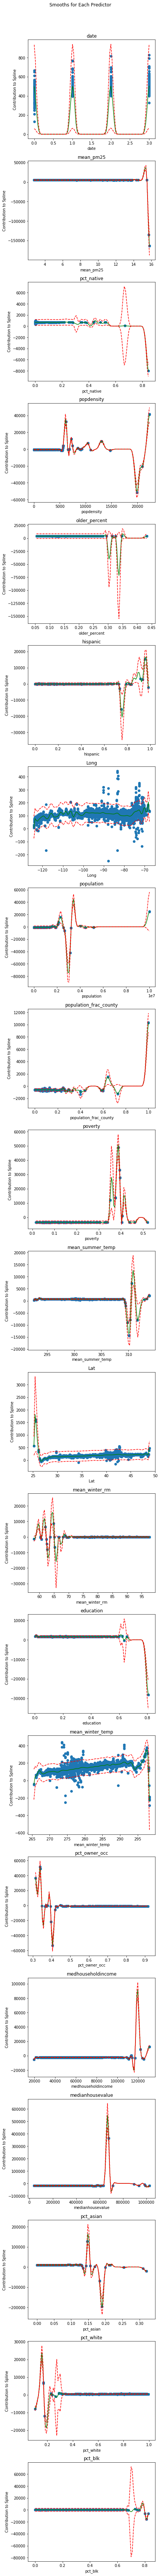

In [129]:
#plot the smooth of each predictor
res = gam.deviance_residuals(X_train[predictors], X_train.cum_deaths) 
X = X_train[predictors]

fig, ax = plt.subplots(21, 1, figsize = (6, 100))

#iterate through each predictor
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue
    XX = gam.generate_X_grid(term = i)
    pdep, confi = gam.partial_dependence(term = i, X = XX, width=0.95)
    pdep2, _ = gam.partial_dependence(term = i, X = X, width=0.95)
    #plt.figure()
    ax[i].scatter(X.iloc[:,term.feature], pdep2 + res)
    ax[i].plot(XX[:, term.feature], pdep, c = 'g')
    ax[i].plot(XX[:, term.feature], confi, c = 'r', ls='--')
    ax[i].set_title(X.columns.values[term.feature])
    ax[i].set_xlabel(X.columns.values[term.feature])
    ax[i].set_ylabel('Contribution to Spline')
    #ax[i].show()

#add title
fig.suptitle('Smooths for Each Predictor')
plt.tight_layout(rect = [0, 0.03, 1, 0.97]);

### kNN

In [96]:
from sklearn.preprocessing import MinMaxScaler
# Create a scaler using the training data
scaler = MinMaxScaler().fit(X_train[predictors])
# make copies
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
# Use the scaler to normalize the training and test data
X_train_scaled[predictors] = scaler.transform(X_train[predictors])
X_test_scaled[predictors] = scaler.transform(X_test[predictors])
X_train_scaled = X_train_scaled[predictors]
X_test_scaled = X_test_scaled[predictors]

In [125]:
from sklearn.neighbors import KNeighborsRegressor
ks = [1,2,3,4,5,6,8,10,12,15]
meanscores = []
y_train = X_train.cum_deaths
y_test = X_test.cum_deaths
# SWAP THIS OUT - CROSS_VAL_SCORE
for k in ks: 
    scores = []
    knn = KNeighborsRegressor(k)
    for train_index, test_index in kf.split(X_train_scaled):
        knn.fit(X_train_scaled.iloc[train_index], y_train.iloc[train_index])
        scores.append(mean_squared_error(knn.predict(X_train_scaled.iloc[test_index]), y_train.iloc[test_index]))
    meanscores.append(np.mean(scores))

In [126]:
k = ks[meanscores.index(min(meanscores))]
knn = KNeighborsRegressor(k)
knn.fit(X_train_scaled, y_train)
print('Optimal Number of Neighbors:', k, 
      '\nMSE on Training Set:', mean_squared_error(knn.predict(X_train_scaled), y_train), 
      '\nMSE on Test Set:', mean_squared_error(knn.predict(X_test_scaled), y_test))

Optimal Number of Neighbors: 3 
MSE on Training Set: 1232.6955585464334 
MSE on Test Set: 3110.5585196476964
